# Libraries

In [7]:
# Data set 
from tensorflow.keras.datasets import mnist
# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
# Logistic Regression
import numpy as np
from sklearn.linear_model import LogisticRegression
# Tenser Flow  for RMS Promp
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
# Accuracy
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# hyper parameters tunng 
from keras_tuner import RandomSearch
import kerastuner as kt
from keras.optimizers import Adam


# Load MNIST Data set 

In [2]:
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# Data Set Overview

Before normalization:
Max pixel value: 255
Min pixel value: 0


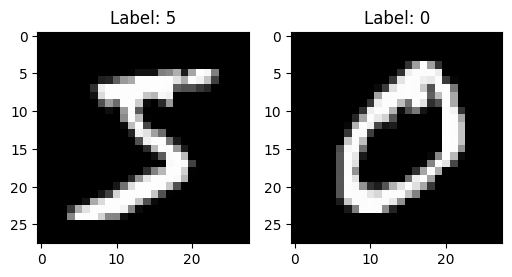

In [3]:
print("Before normalization:")
print("Max pixel value:", train_images.max())
print("Min pixel value:", train_images.min())
plt.figure(figsize=(6, 3))

plt.subplot(1, 2, 1)
plt.imshow(train_images[0], cmap='gray')
plt.title(f"Label: {train_labels[0]}")
plt.subplot(1, 2, 2)
plt.imshow(train_images[1], cmap='gray')
plt.title(f"Label: {train_labels[1]}")

plt.show()

# -----------------------------Pre PRocessing------------------------------

### Normalization


After normalization:
Max pixel value: 1.0
Min pixel value: 0.0


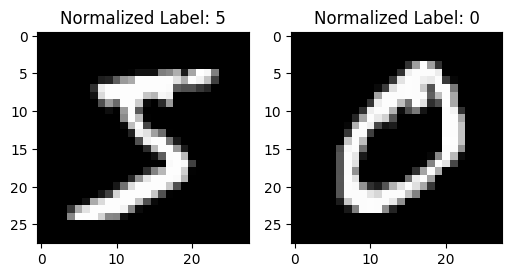

In [4]:

train_images_normalized = train_images.astype('float32') / 255.0
test_images_normalized = test_images.astype('float32') / 255.0
print("\nAfter normalization:")
print("Max pixel value:", train_images_normalized.max())
print("Min pixel value:", train_images_normalized.min())
plt.figure(figsize=(6, 3))

plt.subplot(1, 2, 1)
plt.imshow(train_images_normalized[0], cmap='gray')
plt.title(f"Normalized Label: {train_labels[0]}")

plt.subplot(1, 2, 2)
plt.imshow(train_images_normalized[1], cmap='gray')
plt.title(f"Normalized Label: {train_labels[1]}")

plt.show()

### StandardScaler

Train images mean (after standardization): -4.987327217875759e-10
Train images std (after standardization): 0.9563164114952087


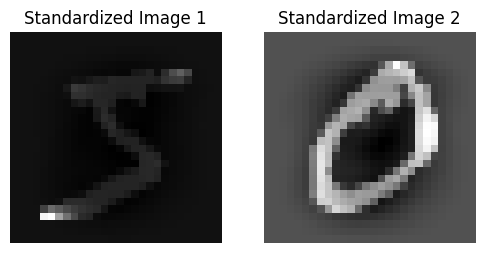

In [5]:
scaler = StandardScaler()
train_images_reshaped = train_images_normalized.reshape((train_images.shape[0], -1))
test_images_reshaped = test_images_normalized.reshape((test_images.shape[0], -1))
train_images_standardized = scaler.fit_transform(train_images_reshaped)
test_images_standardized = scaler.transform(test_images_reshaped)
print(f"Train images mean (after standardization): {train_images_standardized.mean()}")
print(f"Train images std (after standardization): {train_images_standardized.std()}")
standardized_image_1 = train_images_standardized[0].reshape(28, 28)
standardized_image_2 = train_images_standardized[1].reshape(28, 28)

plt.figure(figsize=(6, 3))
for i, img in enumerate([standardized_image_1, standardized_image_2]):
    plt.subplot(1, 2, i+1)
    plt.imshow(img, cmap='gray')
    plt.title(f"Standardized Image {i+1}")
    plt.axis('off')
plt.show()

### PCA

In [6]:
pca = PCA(n_components=0.95)  # Retain 95% of the variance
preprosess_train_images = pca.fit_transform(train_images_standardized)
preprocess_test_images = pca.transform(test_images_standardized)
print(f"Original number of features: {train_images_standardized.shape[1]}")
print(f"Reduced number of features after PCA (train): {preprosess_train_images.shape[1]}")
print(f"Reduced number of features after PCA (test): {preprocess_test_images.shape[1]}")


# Ensure the number of samples in train and test sets are consistent with labels
if preprosess_train_images.shape[0] != train_labels.shape[0]:
    raise ValueError(f"Training images PCA shape mismatch: {preprosess_train_images.shape[0]} vs {train_labels.shape[0]}")

if preprocess_test_images.shape[0] != test_labels.shape[0]:
    raise ValueError(f"Test images PCA shape mismatch: {preprocess_test_images.shape[0]} vs {test_labels.shape[0]}")

Original number of features: 784
Reduced number of features after PCA (train): 331
Reduced number of features after PCA (test): 331


# General functions of Logistic Regression

In [31]:
def train_log_reg(train_images, train_labels, max_iter=1000, optimizer=None, use_tensorflow=False, learning_rate=0.001, epochs=10, use_batch_norm=False, weights=None, bias=None):
    if use_tensorflow:
        model = models.Sequential()
        model.add(layers.InputLayer(input_shape=train_images.shape[1:]))  # Use InputLayer for more flexibility
        if use_batch_norm:
            model.add(layers.BatchNormalization())
        model.add(layers.Dense(10, activation='softmax'))  # Assuming 10 classes for MNIST
        
        # Check if weights and biases are provided
        if weights is not None and bias is not None:
            model.layers[-1].set_weights([weights, bias])  # Set weights and biases for the last layer
            
        # Default optimizer is Adam if none is provided
        if optimizer is None:
            optimizer = Adam(learning_rate=learning_rate)
        elif optimizer.lower() == 'nag':
            optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9, nesterov=True)
        else:
            optimizer_class = getattr(tf.keras.optimizers, optimizer.capitalize(), None)
            if optimizer_class is None:
                raise ValueError(f"Optimizer {optimizer} not recognized.")
            optimizer = optimizer_class(learning_rate=learning_rate)

        model.compile(optimizer=optimizer,
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])

        # Train the model
        model.fit(train_images, train_labels, epochs=epochs)
        return model
    else:
        # Use scikit-learn's Logistic Regression if not using TensorFlow
        if optimizer is None:
            log_reg_model = LogisticRegression(max_iter=max_iter, random_state=42)
        else:
            log_reg_model = LogisticRegression(max_iter=max_iter, solver=optimizer, random_state=42)

        # Train the logistic regression model using scikit-learn
        log_reg_model.fit(train_images, train_labels)
        return log_reg_model


# General Evaluation Model

In [50]:
def evaluate_log_reg(model, test_images, test_labels, history=None, loss_history=None, use_tensorflow=False):
    if use_tensorflow:
        # For TensorFlow model, predict class probabilities
        probabilities = model.predict(test_images)
        predictions = np.argmax(probabilities, axis=1)  
    else:
        # For scikit-learn model
        predictions = model.predict(test_images)  
    
    # Evaluate the model
    accuracy = accuracy_score(test_labels, predictions)
    precision = precision_score(test_labels, predictions, average='weighted')
    recall = recall_score(test_labels, predictions, average='weighted')
    f1 = f1_score(test_labels, predictions, average='weighted')

    print(f"Model Accuracy: {accuracy:.4f}")
    print(f"Model Precision: {precision:.4f}")
    print(f"Model Recall: {recall:.4f}")
    print(f"Model F1 Score: {f1:.4f}")

    # Print classification report
    print("\nClassification Report:")
    print(classification_report(test_labels, predictions))

    # Confusion Matrix
    cm = confusion_matrix(test_labels, predictions)
    plt.figure(figsize=(10, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

    # Visualize class separation in PCA space (assuming PCA has been applied to test_images)
    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(test_images[:, 0], test_images[:, 1], c=predictions, cmap='viridis', alpha=0.5)
    legend1 = plt.legend(*scatter.legend_elements(), title="Classes")
    plt.gca().add_artist(legend1)
    plt.title("PCA of Test Dataset with Logistic Regression Predictions")
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.colorbar(scatter, label='Predicted Classes')
    plt.show()

    # Additional visualizations
    metrics = {'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1 Score': f1}
    
    plt.figure(figsize=(10, 5))
    plt.bar(metrics.keys(), metrics.values(), color=['blue', 'orange', 'green', 'red'])
    plt.ylim(0, 1)
    plt.title('Model Performance Metrics')
    plt.ylabel('Score')
    plt.show()

    # Plot training and validation loss/accuracy over time if history is provided
    if history is not None:
        plt.figure(figsize=(12, 6))

        # Plot training & validation accuracy values
        plt.subplot(1, 2, 1)
        plt.plot(history.history['accuracy'], label='Train Accuracy')
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
        plt.title('Model Accuracy')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend(loc='upper left')

        # Plot training & validation loss values
        plt.subplot(1, 2, 2)
        plt.plot(history.history['loss'], label='Train Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title('Model Loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(loc='upper left')

        plt.tight_layout()
        plt.show()

    # Plot convergence of loss function over time if loss_history is provided
    if loss_history is not None:
        plt.figure(figsize=(10, 6))
        plt.plot(loss_history, label='Training Loss')
        plt.title('Convergence of Loss Function Over Time')
        plt.ylabel('Loss')
        plt.xlabel('Epochs')
        plt.legend()
        plt.show()

    return accuracy, predictions

# Chuse the Hyper Parameter

In [10]:
def model_builder(hp):
    # Get hyperparameters from KerasTuner
    learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-1, sampling='LOG')
    epochs = hp.Int('epochs', min_value=5, max_value=100, step=5)
    batch_size = hp.Int('batch_size', min_value=16, max_value=128, step=16)
    model = train_log_reg(preprosess_train_images, train_labels, optimizer='adam', 
                          use_tensorflow=True, epochs=epochs, learning_rate=learning_rate)

    return model

In [9]:
val_split = 0.2  
split_index = int((1 - val_split) * len(preprosess_train_images))
train_images_hp, val_images_hp = preprosess_train_images[:split_index], preprosess_train_images[split_index:]
train_labels_hp, val_labels_hp = train_labels[:split_index], train_labels[split_index:]
print("Total samples in preprocessed training images:", preprosess_train_images.shape[0])
print("Total samples in training labels:", train_labels.shape[0])

Total samples in preprocessed training images: 60000
Total samples in training labels: 60000


# Find the best model From Tuner

In [11]:
tuner = kt.Hyperband(
    model_builder,
    objective='val_accuracy',
    max_epochs=100,
    factor=3,
    directory='my_dir',
    project_name='log_reg_tuning'
)
best_model = tuner.get_best_models(num_models=1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

# Output the best hyperparameters from the saved trials
print("Best Hyperparameters from saved trials:")
learning_rate = best_hyperparameters.get('learning_rate')
epochs = best_hyperparameters.get('epochs')
batch_size = best_hyperparameters.get('batch_size')

print(f"Learning Rate: {learning_rate}")
print(f"Number of Epochs: {epochs}")
print(f"Batch Size: {batch_size}")

Reloading Tuner from my_dir\log_reg_tuning\tuner0.json



c:\Users\mahma\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.3544 - loss: 2.3468
Epoch 2/100
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 995us/step - accuracy: 0.8578 - loss: 0.5784
Epoch 3/100
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8948 - loss: 0.4023
Epoch 4/100
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9087 - loss: 0.3443
Epoch 5/100
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9150 - loss: 0.3114
Epoch 6/100
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 954us/step - accuracy: 0.9173 - loss: 0.2981
Epoch 7/100
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9199 - loss: 0.2909
Epoch 8/100
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 993us/step - accuracy: 0.9197 - loss: 0.2852
Epoch 9/100
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 952us/step - accuracy: 0.9234 - loss: 0.2744
Epoch 10/100
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9239 - loss: 0.2704
Epoch 11/100
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 992us/step - accuracy: 0.9239 - loss: 0.2721
Epoch 12/

# Without Batch Normalization

In [12]:
model_without_bn = train_log_reg(
    train_images_hp, train_labels_hp,
    learning_rate=learning_rate,
    epochs=epochs,
    optimizer='adam',  
    use_tensorflow=True,
    use_batch_norm=False
)

Epoch 1/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.3520 - loss: 2.3106
Epoch 2/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8386 - loss: 0.6446
Epoch 3/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8794 - loss: 0.4650
Epoch 4/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9003 - loss: 0.3697
Epoch 5/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9086 - loss: 0.3342
Epoch 6/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9125 - loss: 0.3198
Epoch 7/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 1s 951us/step - accuracy: 0.9169 - loss: 0.3030
Epoch 8/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9177 - loss: 0.2964
Epoch 9/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9194 - loss: 0.2915
Epoch 10/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9237 - loss: 0.2773
Epoch 11/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9249 - loss: 0.2722
Epoch 12/100
1500

Epoch 1/100
3000/3000 - 5s - 2ms/step - accuracy: 0.9303 - loss: 0.2480 - val_accuracy: 0.9277 - val_loss: 0.2867
Epoch 2/100
3000/3000 - 4s - 1ms/step - accuracy: 0.9307 - loss: 0.2472 - val_accuracy: 0.9281 - val_loss: 0.2855
Epoch 3/100
3000/3000 - 4s - 1ms/step - accuracy: 0.9305 - loss: 0.2470 - val_accuracy: 0.9280 - val_loss: 0.2865
Epoch 4/100
3000/3000 - 3s - 1ms/step - accuracy: 0.9298 - loss: 0.2470 - val_accuracy: 0.9275 - val_loss: 0.2862
Epoch 5/100
3000/3000 - 3s - 1ms/step - accuracy: 0.9307 - loss: 0.2468 - val_accuracy: 0.9282 - val_loss: 0.2858
Epoch 6/100
3000/3000 - 3s - 1ms/step - accuracy: 0.9306 - loss: 0.2469 - val_accuracy: 0.9288 - val_loss: 0.2861
Epoch 7/100
3000/3000 - 5s - 2ms/step - accuracy: 0.9303 - loss: 0.2468 - val_accuracy: 0.9287 - val_loss: 0.2854
Epoch 8/100
3000/3000 - 3s - 1ms/step - accuracy: 0.9309 - loss: 0.2464 - val_accuracy: 0.9279 - val_loss: 0.2868
Epoch 9/100
3000/3000 - 5s - 2ms/step - accuracy: 0.9307 - loss: 0.2467 - val_accuracy: 

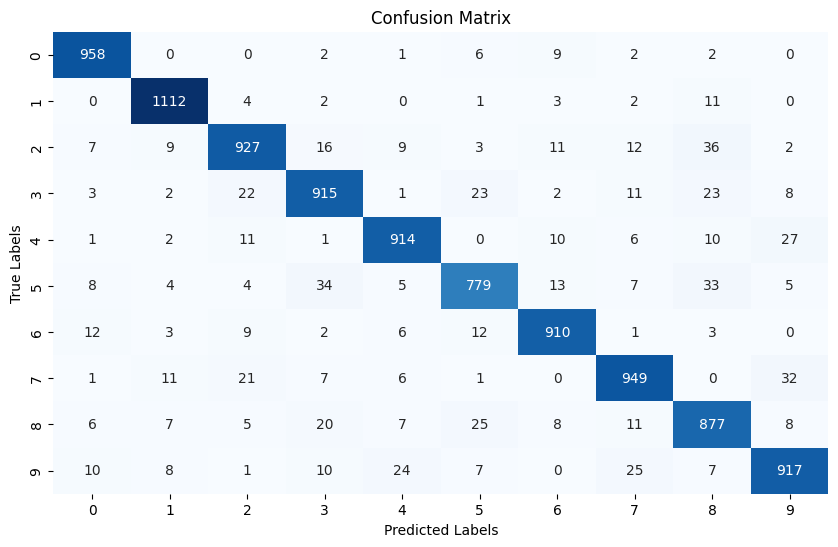

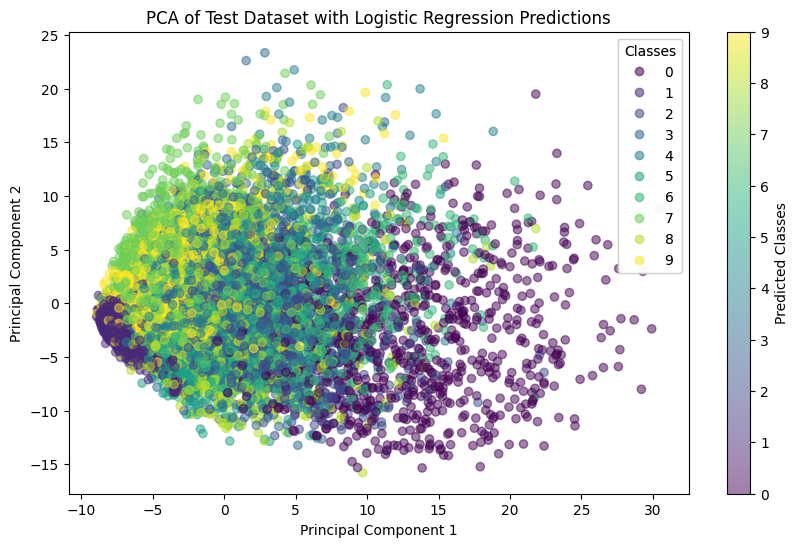

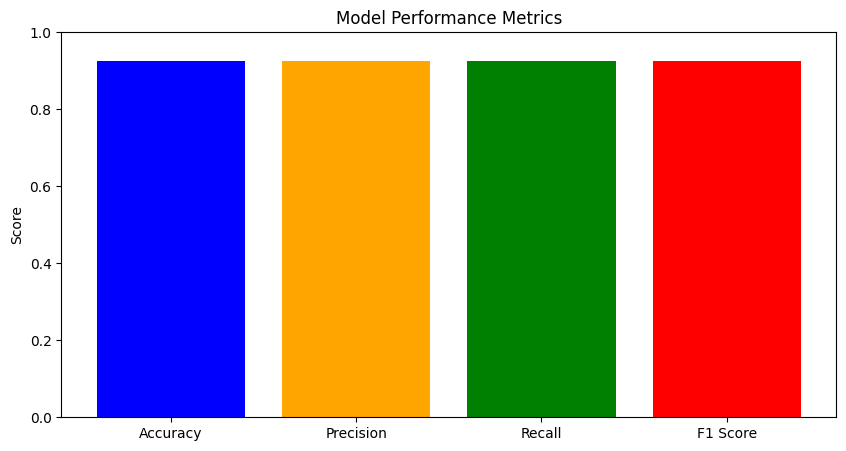

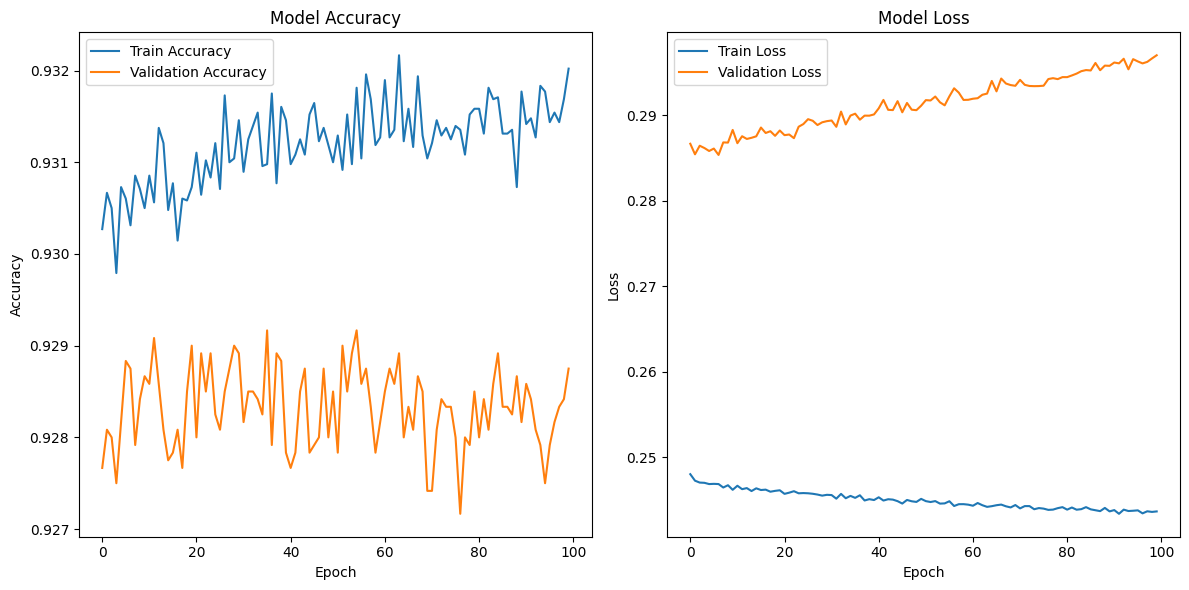

(0.9258, array([7, 2, 1, ..., 4, 5, 6], dtype=int64))

In [14]:
history_without_bn = model_without_bn.fit(train_images_hp, train_labels_hp, epochs=epochs, batch_size=batch_size,validation_data=(val_images_hp, val_labels_hp),verbose=2)
evaluate_log_reg(model_without_bn, preprocess_test_images, test_labels, history=history_without_bn, use_tensorflow=True)

# With BAtch Normalization 

In [15]:
model_with_bn = train_log_reg(train_images_hp, train_labels_hp,learning_rate=learning_rate,epochs=epochs, optimizer='adam',  use_tensorflow=True,use_batch_norm=True)
history_with_bn = model_with_bn.fit(train_images_hp, train_labels_hp, epochs=epochs, batch_size=batch_size,validation_data=(val_images_hp, val_labels_hp),verbose=2)


Epoch 1/100


c:\Users\mahma\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.2374 - loss: 2.4861
Epoch 2/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7516 - loss: 1.0268
Epoch 3/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8540 - loss: 0.5995
Epoch 4/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8806 - loss: 0.4573
Epoch 5/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8926 - loss: 0.4062
Epoch 6/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.8954 - loss: 0.3732
Epoch 7/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8972 - loss: 0.3575
Epoch 8/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8973 - loss: 0.3566
Epoch 9/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9031 - loss: 0.3356
Epoch 10/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9043 - loss: 0.3397
Epoch 11/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9077 - loss: 0.3265
Epoch 12/100
1500/1500 ━━━━━━━━

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Model Accuracy: 0.9201
Model Precision: 0.9199
Model Recall: 0.9201
Model F1 Score: 0.9199

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.98      0.96       980
           1       0.96      0.98      0.97      1135
           2       0.93      0.89      0.91      1032
           3       0.90      0.90      0.90      1010
           4       0.92      0.93      0.93       982
           5       0.90      0.87      0.88       892
           6       0.92      0.95      0.94       958
           7       0.92      0.91      0.92      1028
           8       0.87      0.88      0.88       974
           9       0.91      0.90      0.91      1009

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000



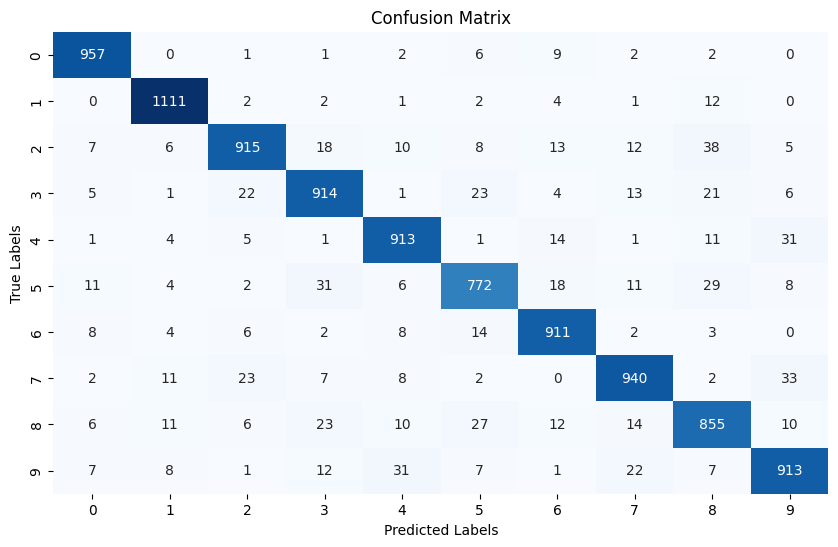

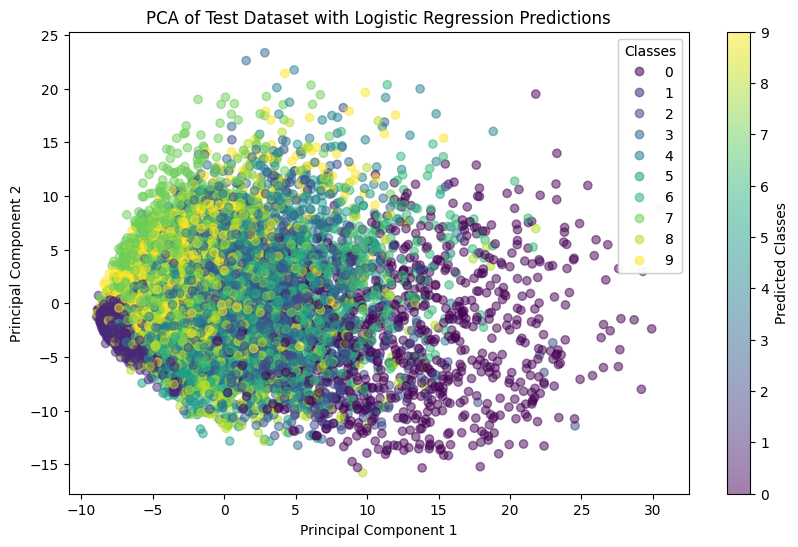

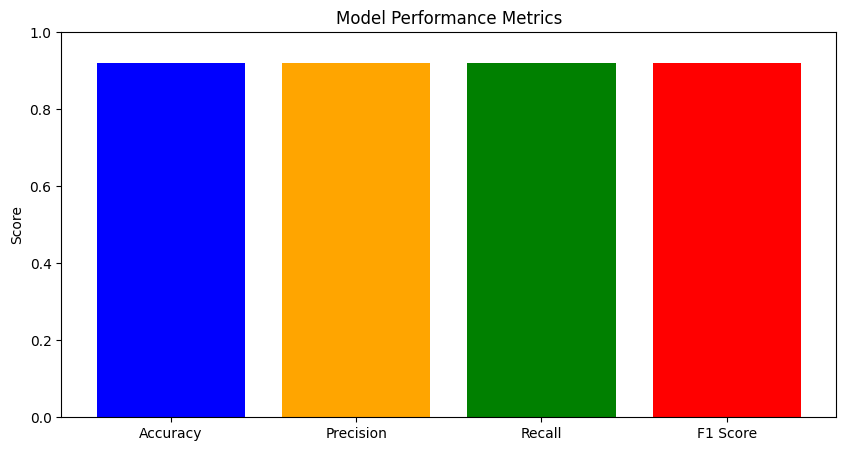

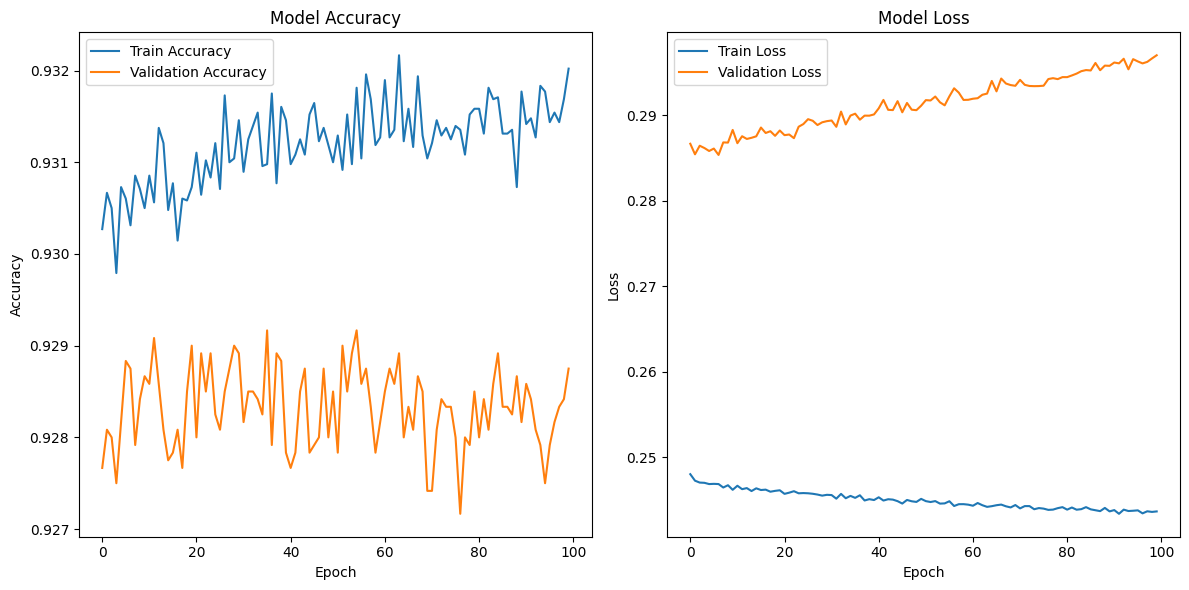

(0.9201, array([7, 2, 1, ..., 4, 5, 6], dtype=int64))

In [16]:
evaluate_log_reg(model_with_bn, preprocess_test_images, test_labels, history=history_without_bn, use_tensorflow=True)

# ---------------------------------Q3-------------------------------

# Basic Gradient Descent function

In [45]:
def basic_gradient_descent(X, y, learning_rate=0.01, epochs=100, num_classes=10):
    m, n = X.shape
    weights = np.zeros((n, num_classes))  
    bias = np.zeros(num_classes)   
    losses = [] 

    for _ in range(epochs):
        logits = np.dot(X, weights) + bias
        exp_logits = np.exp(logits - np.max(logits, axis=1, keepdims=True))  
        y_pred = exp_logits / np.sum(exp_logits, axis=1, keepdims=True)
        y_one_hot = np.zeros((m, num_classes))
        y_one_hot[np.arange(m), y] = 1 
        loss = -np.mean(np.sum(y_one_hot * np.log(y_pred + 1e-9), axis=1))
        losses.append(loss) 
        error = y_pred - y_one_hot
        weights -= learning_rate * (1/m) * np.dot(X.T, error)
        bias -= learning_rate * np.mean(error, axis=0)

    return weights, bias, losses


# Stochastic Gradient Descent (SGD)

In [42]:
def stochastic_gradient_descent(X, y, learning_rate=0.01, epochs=1000, num_classes=10):
    m, n = X.shape
    weights = np.zeros((n, num_classes))  
    bias = np.zeros(num_classes)           
    y_one_hot = np.zeros((m, num_classes))
    y_one_hot[np.arange(m), y] = 1 

    losses = []  

    for epoch in range(epochs):
        epoch_loss = 0  
        for i in range(m):
            logits = np.dot(X[i], weights) + bias

            exp_logits = np.exp(logits - np.max(logits))  
            y_pred = exp_logits / np.sum(exp_logits)
            error = y_pred - y_one_hot[i]
            weights -= learning_rate * np.outer(X[i], error)
            bias -= learning_rate * error
            loss = -np.sum(y_one_hot[i] * np.log(y_pred + 1e-9)) 
            epoch_loss += loss
        losses.append(epoch_loss / m)

    return weights, bias, losses


# Mini-batch Gradient Descent

In [43]:
def mini_batch_gradient_descent(X, y, learning_rate=0.01, epochs=1000, batch_size=32, num_classes=10):
    m, n = X.shape
    weights = np.zeros((n, num_classes))  
    bias = np.zeros(num_classes)          
    y_one_hot = np.zeros((m, num_classes))
    y_one_hot[np.arange(m), y] = 1
    losses = []  
    for epoch in range(epochs):
        epoch_loss = 0 
        indices = np.random.permutation(m)
        X_shuffled = X[indices]
        y_shuffled = y_one_hot[indices]
        for i in range(0, m, batch_size):
            X_batch = X_shuffled[i:i + batch_size]
            y_batch = y_shuffled[i:i + batch_size]
            logits = np.dot(X_batch, weights) + bias
            exp_logits = np.exp(logits - np.max(logits, axis=1, keepdims=True))
            y_pred = exp_logits / np.sum(exp_logits, axis=1, keepdims=True)
            error = y_pred - y_batch
            weights -= learning_rate * (1/batch_size) * np.dot(X_batch.T, error)
            bias -= learning_rate * (1/batch_size) * np.sum(error, axis=0)
            batch_loss = -np.sum(y_batch * np.log(y_pred + 1e-9)) 
            epoch_loss += batch_loss
        losses.append(epoch_loss / m)

    return weights, bias, losses


In [46]:
weights_bg, bias_bg, losses_bg = basic_gradient_descent(preprosess_train_images, train_labels, learning_rate=0.001, epochs=100, num_classes=10)
weights_sgd, bias_sgd, losses_sgd = stochastic_gradient_descent(preprosess_train_images, train_labels, learning_rate=0.001, epochs=100, num_classes=10)
weights_mbgd, bias_mbgd, losses_mbgd = mini_batch_gradient_descent(preprosess_train_images, train_labels, learning_rate=0.001, epochs=100, batch_size=16, num_classes=10)
# Print the results
print("Weights from Basic Gradient Descent:", weights_bg)
print("Bias from Basic Gradient Descent:", bias_bg)

print("Weights from Stochastic Gradient Descent:", weights_sgd)
print("Bias from Stochastic Gradient Descent:", bias_sgd)

print("Weights from Mini-batch Gradient Descent:", weights_mbgd)
print("Bias from Mini-batch Gradient Descent:", bias_mbgd)

Weights from Basic Gradient Descent: [[ 8.62839899e-02 -6.52304633e-02  2.30838012e-02 ... -2.94997460e-02
  -6.90642600e-03 -2.30927090e-02]
 [-2.46181054e-02 -1.80986640e-02 -5.85869053e-03 ...  3.42005167e-02
  -1.22495885e-02  2.65135096e-02]
 [-1.89426304e-02  3.24247101e-02  5.01783961e-02 ... -5.55288463e-02
   5.39220120e-03 -4.01863531e-02]
 ...
 [ 7.55842299e-05 -1.06081057e-05 -3.21053333e-06 ...  3.95008870e-05
   7.15617186e-06 -6.74123596e-05]
 [-2.14731593e-05 -9.74974659e-05 -6.23942924e-05 ...  2.37651959e-05
   6.25256264e-05 -5.34441469e-05]
 [ 4.41670585e-05 -1.46284357e-05 -1.39151738e-04 ...  3.33659500e-05
   1.45572808e-04 -1.41072778e-04]]
Bias from Basic Gradient Descent: [-5.70299087e-04  9.87936104e-04 -3.42231040e-05  2.82462370e-04
 -1.19399486e-04 -7.42146980e-04 -1.15861502e-04  3.50445349e-04
 -5.19920120e-05  1.30783481e-05]
Weights from Stochastic Gradient Descent: [[ 0.930356   -0.63586858  0.30918797 ... -0.43972658  0.07562251
  -0.40493043]
 [-0.4

# BAsic Gradient

In [39]:
log_reg_model_tf = train_log_reg(preprosess_train_images, train_labels, use_tensorflow=True, epochs=100, use_batch_norm=True, weights=weights_bg, bias=bias_bg)

Epoch 1/100
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.8264 - loss: 0.9750
Epoch 2/100
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 21s 6ms/step - accuracy: 0.9020 - loss: 0.3451
Epoch 3/100
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.9031 - loss: 0.3340
Epoch 4/100
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.9049 - loss: 0.3271
Epoch 5/100
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.9079 - loss: 0.3233
Epoch 6/100
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - accuracy: 0.9068 - loss: 0.3283
Epoch 7/100
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - accuracy: 0.9038 - loss: 0.3258
Epoch 8/100
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - accuracy: 0.9044 - loss: 0.3244
Epoch 9/100
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - accuracy: 0.9076 - loss: 0.3238
Epoch 10/100
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.9081 - loss: 0.3226
Epoch 11/100
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.9093 - loss: 0.3112
Epoch 12

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Model Accuracy: 0.9236
Model Precision: 0.9237
Model Recall: 0.9236
Model F1 Score: 0.9235

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.97      0.97       980
           1       0.97      0.98      0.97      1135
           2       0.93      0.88      0.91      1032
           3       0.91      0.90      0.91      1010
           4       0.93      0.94      0.93       982
           5       0.91      0.87      0.89       892
           6       0.93      0.95      0.94       958
           7       0.93      0.91      0.92      1028
           8       0.86      0.90      0.88       974
           9       0.91      0.91      0.91      1009

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000



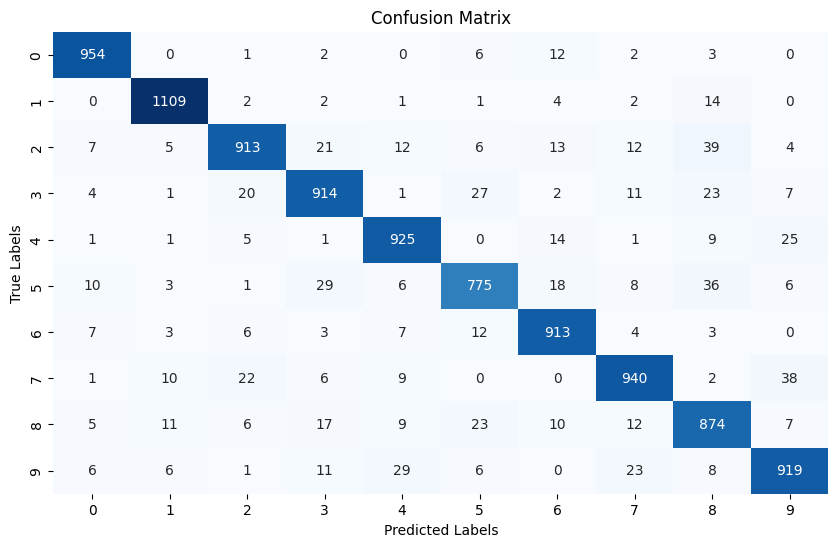

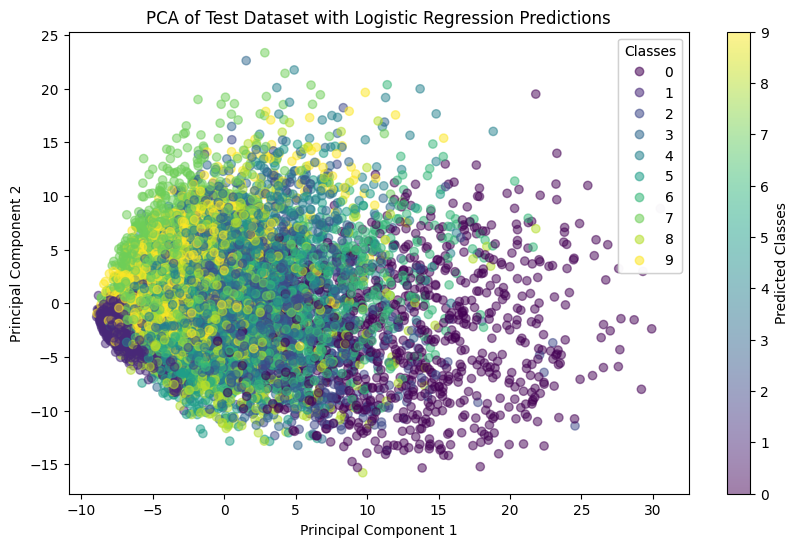

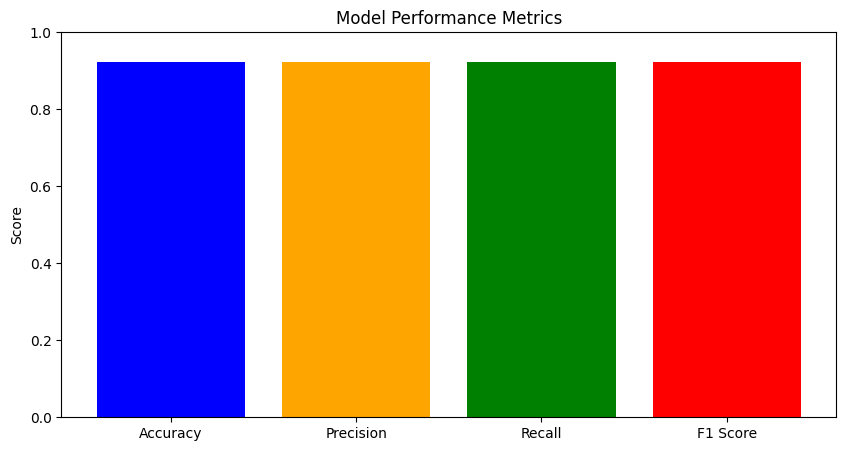

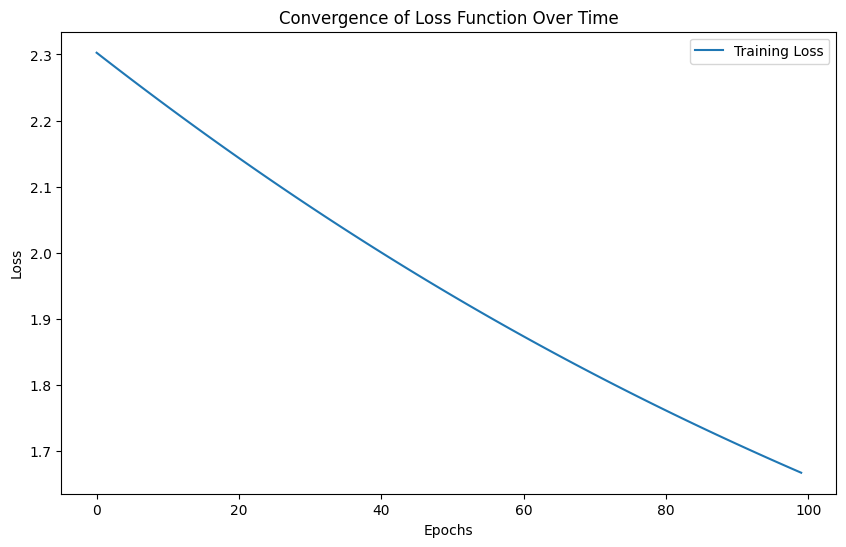

(0.9236, array([7, 2, 1, ..., 4, 5, 6], dtype=int64))

In [52]:
evaluate_log_reg(log_reg_model_tf, preprocess_test_images, test_labels, loss_history=losses_bg, use_tensorflow=True)

# Socastic BAsic Gradient

In [40]:
log_reg_model_tf_SGD = train_log_reg(preprosess_train_images, train_labels, use_tensorflow=True, epochs=100, use_batch_norm=True, weights=weights_sgd, bias=bias_sgd)

c:\Users\mahma\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/100
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.7275 - loss: 0.9194
Epoch 2/100
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.8977 - loss: 0.3453
Epoch 3/100
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9034 - loss: 0.3305
Epoch 4/100
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9063 - loss: 0.3258
Epoch 5/100
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9076 - loss: 0.3209
Epoch 6/100
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9067 - loss: 0.3264
Epoch 7/100
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9074 - loss: 0.3215
Epoch 8/100
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9061 - loss: 0.3232
Epoch 9/100
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9075 - loss: 0.3199
Epoch 10/100
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9084 - loss: 0.3124
Epoch 11/100
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9091 - loss: 0.3144
Epoch 12/100
1875/1

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Model Accuracy: 0.9235
Model Precision: 0.9234
Model Recall: 0.9235
Model F1 Score: 0.9233

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.98      0.97       980
           1       0.95      0.98      0.97      1135
           2       0.92      0.90      0.91      1032
           3       0.90      0.91      0.91      1010
           4       0.93      0.94      0.93       982
           5       0.91      0.87      0.89       892
           6       0.94      0.95      0.94       958
           7       0.93      0.91      0.92      1028
           8       0.87      0.89      0.88       974
           9       0.92      0.90      0.91      1009

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000



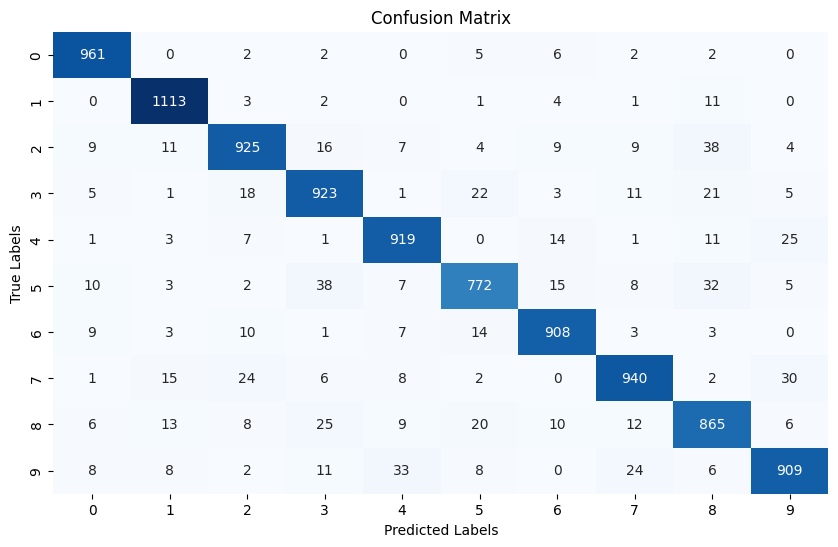

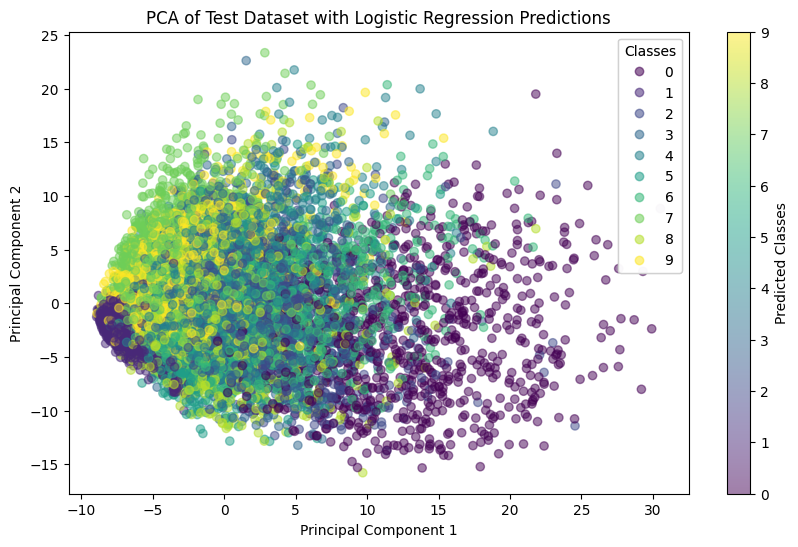

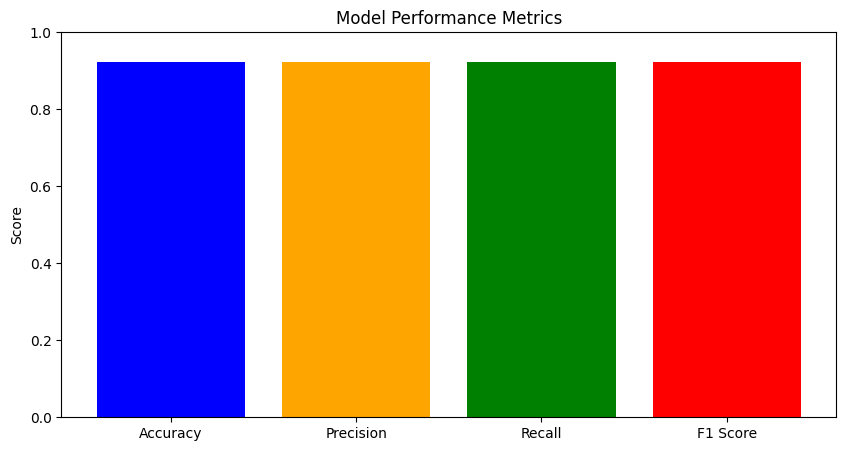

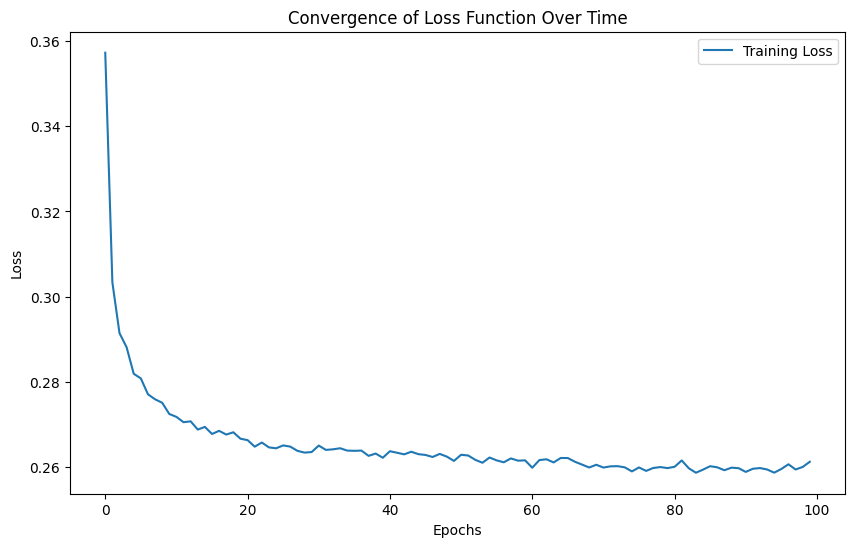

(0.9235, array([7, 2, 1, ..., 4, 5, 6], dtype=int64))

In [53]:
evaluate_log_reg(log_reg_model_tf_SGD, preprocess_test_images, test_labels, loss_history=losses_sgd, use_tensorflow=True)

# Mini Batch  Gradient

In [47]:
log_reg_model_tf_mini = train_log_reg(preprosess_train_images, train_labels, use_tensorflow=True, epochs=100, use_batch_norm=True, weights=weights_mbgd, bias=bias_mbgd)

c:\Users\mahma\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/100
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8330 - loss: 0.5914
Epoch 2/100
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9038 - loss: 0.3364
Epoch 3/100
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9022 - loss: 0.3338
Epoch 4/100
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9066 - loss: 0.3194
Epoch 5/100
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9064 - loss: 0.3208
Epoch 6/100
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9103 - loss: 0.3097
Epoch 7/100
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9072 - loss: 0.3189
Epoch 8/100
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - accuracy: 0.9087 - loss: 0.3152
Epoch 9/100
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9092 - loss: 0.3143
Epoch 10/100
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9065 - loss: 0.3277
Epoch 11/100
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9099 - loss: 0.3120
Epoch 12/100
1875/1

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Model Accuracy: 0.9226
Model Precision: 0.9227
Model Recall: 0.9226
Model F1 Score: 0.9225

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.98      0.97       980
           1       0.97      0.97      0.97      1135
           2       0.93      0.89      0.91      1032
           3       0.90      0.91      0.91      1010
           4       0.93      0.93      0.93       982
           5       0.89      0.87      0.88       892
           6       0.93      0.95      0.94       958
           7       0.92      0.92      0.92      1028
           8       0.86      0.89      0.87       974
           9       0.92      0.90      0.91      1009

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000



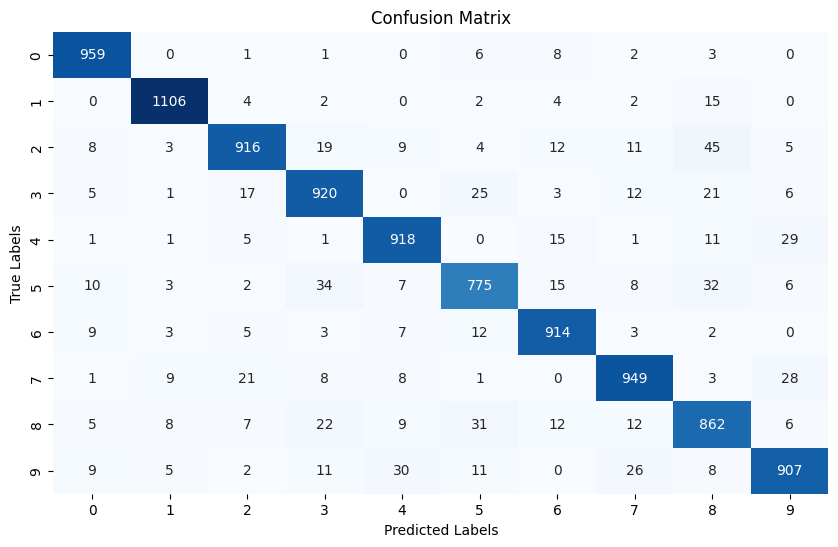

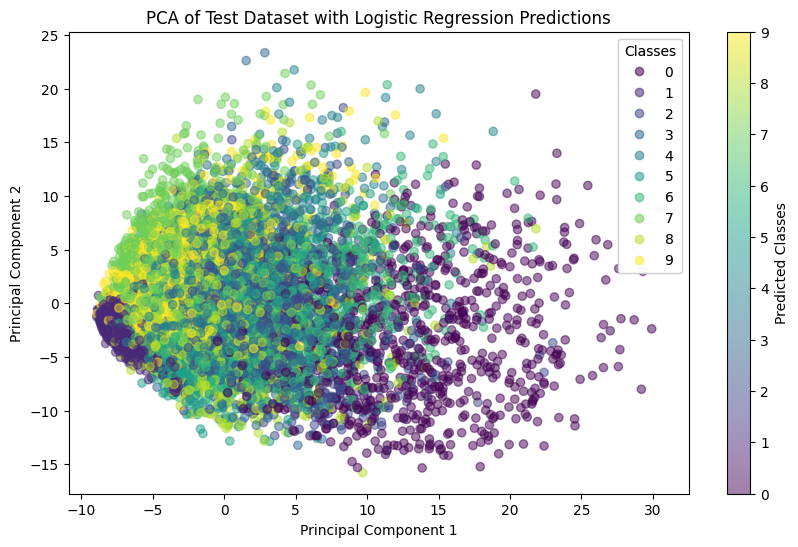

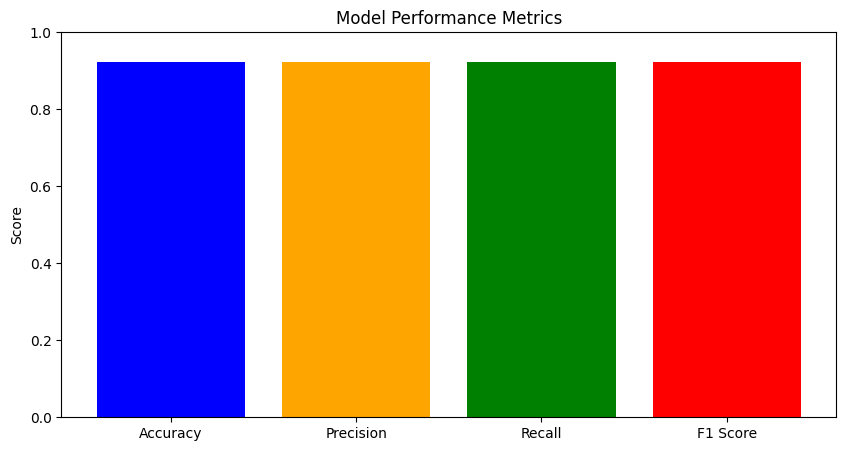

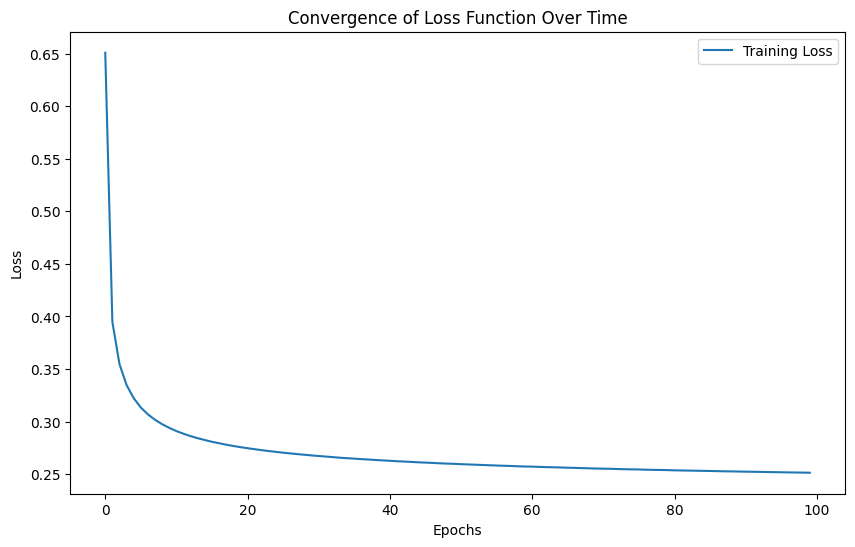

(0.9226, array([7, 2, 1, ..., 4, 5, 6], dtype=int64))

In [54]:
evaluate_log_reg(log_reg_model_tf_mini, preprocess_test_images, test_labels, loss_history=losses_mbgd, use_tensorflow=True)